# Sentiment Analysis of Airline Tweets

**Objective:**  
Predict the sentiment (positive, neutral, negative) of airline customer tweets using a pre-trained NLP model from Hugging Face.  

**Dataset:**  
- Source: Kaggle "Tweets about Airlines" dataset  
- Contains tweets labeled as positive, neutral, or negative  
- Includes columns like `tweet_id`, `text`, `airline_sentiment`, etc.

**Goal:**  
- Clean the tweet text  
- Apply a pre-trained sentiment analysis model (CardiffNLP Twitter RoBERTa)  
- Evaluate the model using accuracy, confusion matrix, and classification report

##  Load the Dataset

- Read the CSV file into a pandas DataFrame
- Inspect the first few rows and basic info
- Check for null values and class distribution

**Insights:**
- Number of tweets: 24640
- Distribution: Negative: 9178, Neutral: 3099, Positive: 2363
- Any missing values: none

In [5]:
!pip install -q kaggle

from google.colab import files #Upload Kaggle API key (kaggle.json)
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"tanikapadayachy","key":"32d38b3c759b98869348803b93ef6a9e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d crowdflower/twitter-airline-sentiment
!unzip -o twitter-airline-sentiment.zip -d twitter_data

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 50.7MB/s]
Archive:  twitter-airline-sentiment.zip
  inflating: twitter_data/Tweets.csv  
  inflating: twitter_data/database.sqlite  


In [3]:
import pandas as pd

data = pd.read_csv('twitter_data/Tweets.csv')

data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# only want text and airline_sentiment
tweets = data[['text', 'airline_sentiment']].copy()

tweets.isnull().sum()

,0
text,0
airline_sentiment,0


In [ ]:
# display sentiment distribution
tweets['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [ ]:
tweets.sample(5)



,text,airline_sentiment,text_length
825,@united yes I filed a claim &amp; hope to rece...,negative,145
6033,@SouthwestAir when you enter every contest for...,negative,78
10546,@USAirways I've been on hold for over 2 1/2 ho...,negative,143
13109,@AmericanAir Thanks. Having issues checking in...,positive,99
13785,@AmericanAir Got my bags this morning! Thanks!,positive,46


In [ ]:
#Determine average tweet size by adding new column text_length
# mentions and URLs are noise for sentiment analysis
tweets['text_length'] = tweets['text'].apply(len)
tweets['text_length'].describe()

,text_length
count,14640.000000
mean,103.822063
std,36.277339
min,12.000000
25%,77.000000
50%,114.000000
75%,136.000000
max,186.000000


## Clean the Tweets

- Remove @mentions, URLs, hashtags, and extra whitespace
- Convert emojis to textual representation
- Convert all text to lowercase
- Store cleaned text in a new column `text_clean`

**Reason:** Clean text improves NLP model performance and ensures consistency.

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
import re
import emoji

def clean_tweet(text, demojize=True):
  if not isinstance(text,str):
    return ""
  #remove mentions
  text = re.sub(r'@\w+','',text)
  #remove URLs
  text = re.sub(r'https?:\/\/\S+','',text)
  #remove hashtags but retain word
  text = text.replace('#','')
  #remove whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  if demojize:
    text = emoji.demojize(text)
  return text

tweets['text_clean'] = tweets['text'].apply(clean_tweet)
tweets[['text', 'text_clean']].head()

,text,text_clean
0,@VirginAmerica What @dhepburn said.,What said.
1,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...
2,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take ano...
3,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent..."
4,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it


##  Apply Hugging Face Pre-trained Model (CardiffNLP)

- Use `cardiffnlp/twitter-roberta-base-sentiment` pipeline
- Predict sentiment for each cleaned tweet
- Store predictions and confidence scores

**Notes:**
- Model outputs `Positive`, `Neutral`, `Negative` labels
- Mapped to lowercase to match dataset labels
- Batch processing is used for efficiency

In [ ]:
!pip install transformers torch

In [ ]:
from transformers import pipeline

sentiment_pipe = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment', tokenizer='cardiffnlp/twitter-roberta-base-sentiment')

tweets_subset = tweets.iloc[:200].copy()
tweets_subset['text_clean'] = tweets_subset['text'].apply(lambda x: x.lower())
texts = tweets_subset['text_clean'].tolist()

Device set to use cpu


In [ ]:
# Batch prediction
batch_size = 64
pred_labels = []
pred_scores = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    out = sentiment_pipe(batch, truncation=True)
    for score in out:# Model returns a single label per tweet
        pred_labels.append(score['label'])
        pred_scores.append(score['score'])

# Print an example of the model's output to inspect the label format
if len(out) > 0:
    print("Example model output:", out[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Example model output: {'label': 'LABEL_0', 'score': 0.9647864699363708}


In [ ]:
# Map model labels to match dataset labels
label_mapping = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
pred_labels_mapped = [label_mapping[label] for label in pred_labels]

# Add predictions to tweets_subset
tweets_subset['hf_label'] = pred_labels_mapped
tweets_subset['hf_score'] = pred_scores

tweets_subset[['text_clean', 'hf_label', 'hf_score']].head()

,text_clean,hf_label,hf_score
0,@virginamerica what @dhepburn said.,neutral,0.817886
1,@virginamerica plus you've added commercials t...,negative,0.825585
2,@virginamerica i didn't today... must mean i n...,neutral,0.556894
3,@virginamerica it's really aggressive to blast...,negative,0.878137
4,@virginamerica and it's a really big bad thing...,negative,0.899221


##  Evaluate Model Predictions

- Compare predicted labels (`hf_label`) with true labels (`airline_sentiment`)
- Metrics used:
  - Accuracy
  - Confusion Matrix
  - Precision, Recall, F1-score (Classification Report)

**Interpretation:**
- Accuracy indicates overall correct predictions
- Confusion matrix highlights misclassified classes
- Classification report shows per-class performance

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = tweets_subset['airline_sentiment']
pred_labels = tweets_subset['hf_label']

# Predict accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.76


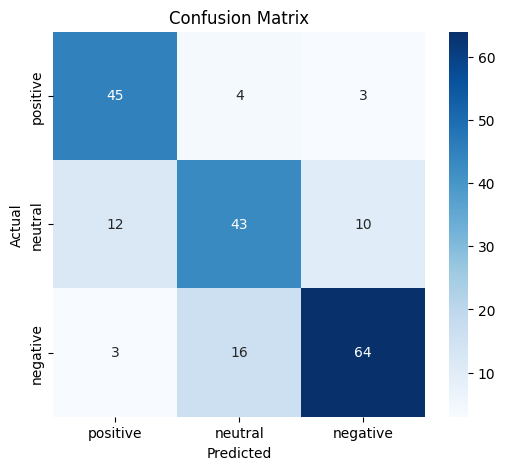

In [ ]:
#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=['positive','neutral','negative'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','neutral','negative'],
            yticklabels=['positive','neutral','negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Classification report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

    negative       0.83      0.77      0.80        83
     neutral       0.68      0.66      0.67        65
    positive       0.75      0.87      0.80        52

    accuracy                           0.76       200
   macro avg       0.75      0.77      0.76       200
weighted avg       0.76      0.76      0.76       200



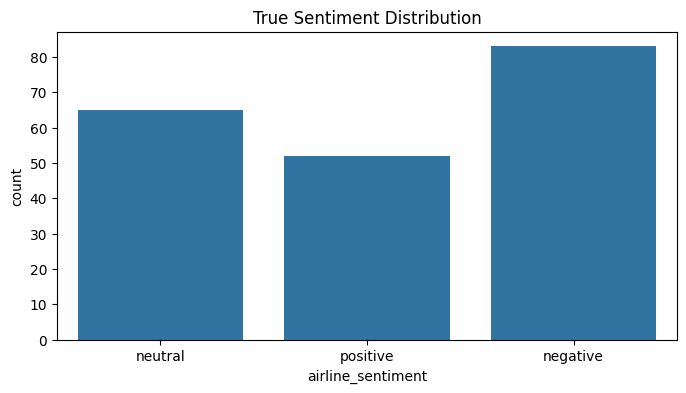

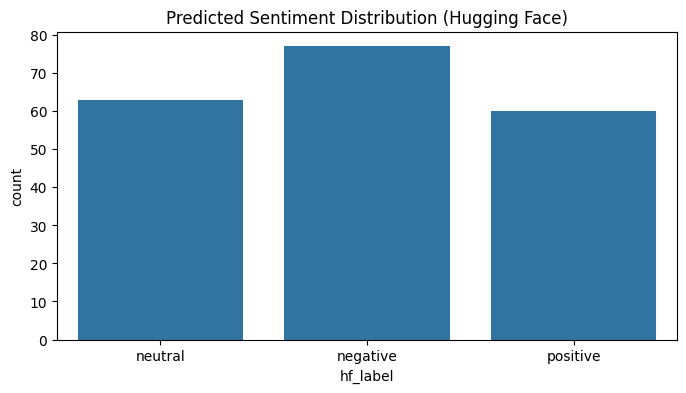

In [ ]:
#Visualize sentiment distribution
plt.figure(figsize=(8,4))
sns.countplot(x='airline_sentiment', data=tweets_subset)
plt.title('True Sentiment Distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='hf_label', data=tweets_subset)
plt.title('Predicted Sentiment Distribution (Hugging Face)')
plt.show()

## Conclusions


- The Hugging Face Twitter model achieved an accuracy of 76% on the subset
- Most misclassifications occurred in the `neutral` class
- Visualizations show that the model captures the general trend of sentiment but struggles with ambiguous tweets or sarcasm